<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Estudios Obligatorios)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Estudios_Obligatorios']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Any                    6132 non-null   int64  
 1   Trimestre              6132 non-null   int64  
 2   Mes                    6132 non-null   int64  
 3   Codi_Districte         6132 non-null   int64  
 4   Nom_Districte          6132 non-null   object 
 5   Codi_Barri             6132 non-null   int64  
 6   Nom_Barri              6132 non-null   object 
 7   Compraventa_Unitario   6132 non-null   float64
 8   Estudios_Obligatorios  6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,97.2
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,97.2


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-01-01,4198.150000,99.2
2016-02-01,4198.150000,99.2
2016-03-01,4198.150000,99.2
2016-04-01,4246.083333,99.2
2016-05-01,4246.083333,99.2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Compraventa_Unitario   84 non-null     float64
 1   Estudios_Obligatorios  84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


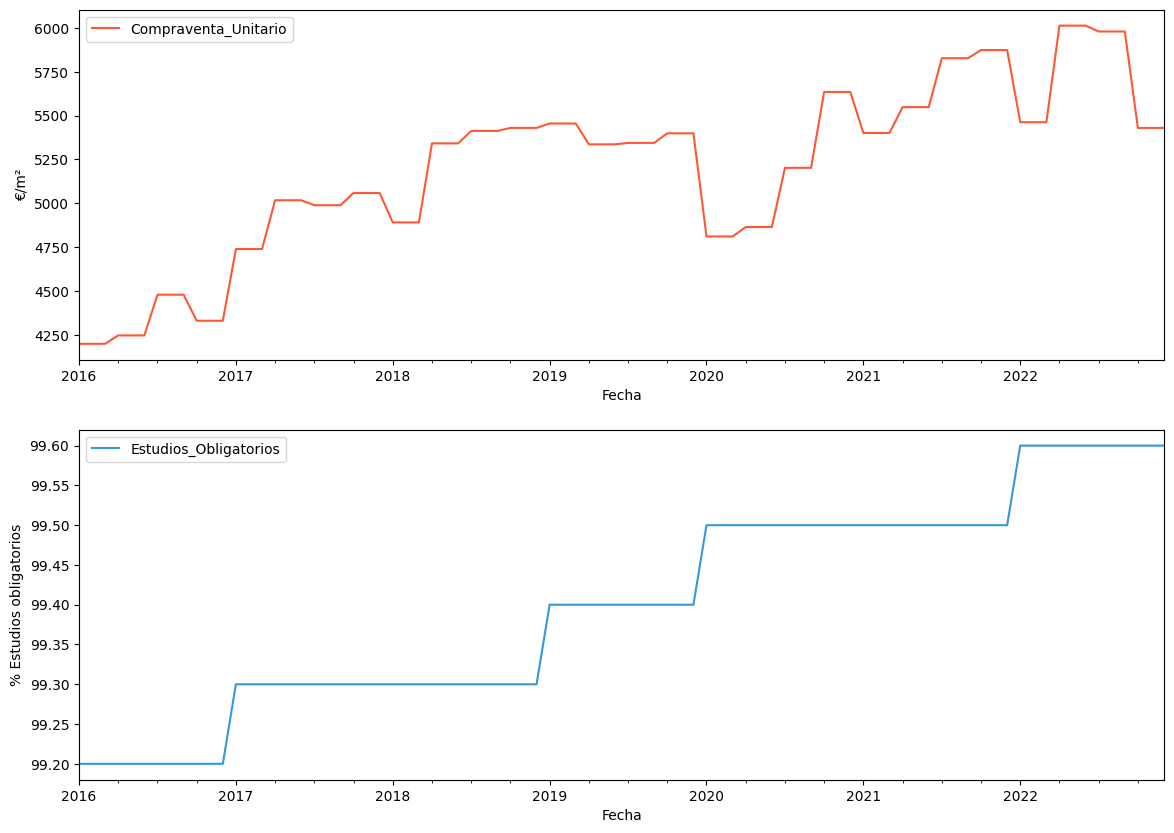

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Estudios obligatorios' ]
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Ambas series temporales muestran una tendencia al alza

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Estudios_Obligatorios
Compraventa_Unitario,1.0000,0.7548
Estudios_Obligatorios,0.7548,1.0000


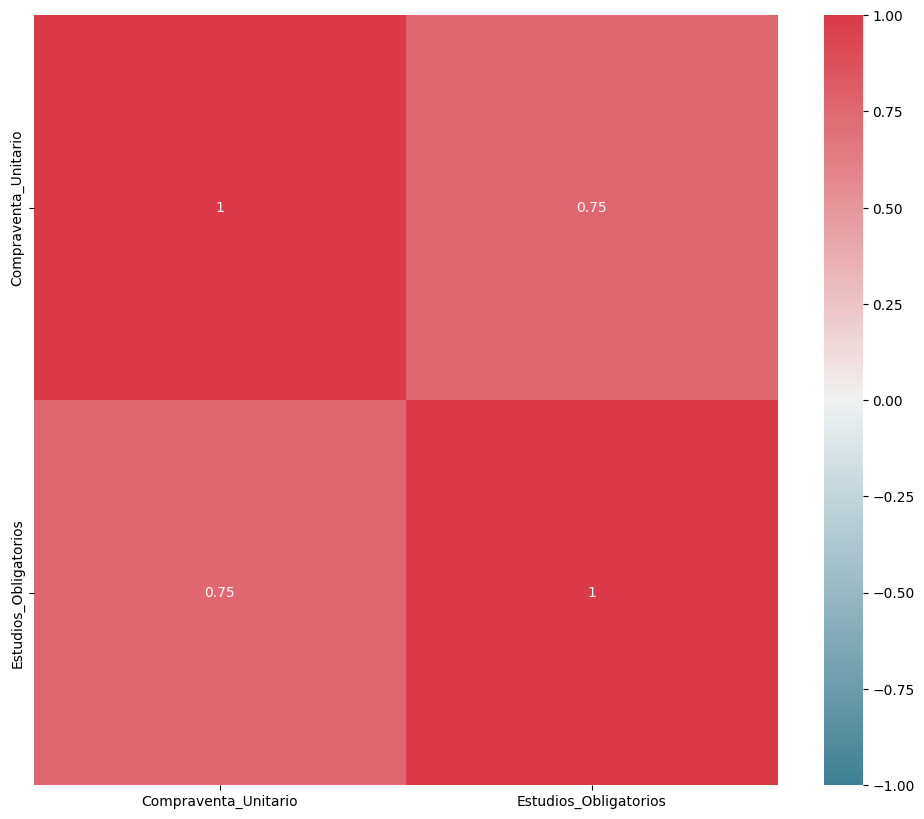

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion, concretamente un 75% de correlacion

### Dividir los datos en conjunto de Entrenamiento y Prueba


In [17]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(72, 2) (12, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario','Estudios_Obligatorios']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  13.13     > 12.3212   =>   True
Estudios_Obligatorios >  1.19      > 4.1296    =>   False


- **Compraventa_Unitario** muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.
- **Estudios_Obligatorios** no muestra evidencia de cointegración, lo que significa que las series relacionadas no tienden a volver a un equilibrio común a largo plazo bajo el modelo actual.

Para un análisis conjunto, dado que una de las series esta cointegrada y la otra no, se consideran principalmente 2 modelos, VAR y VECM

### Prueba de estacionariedad

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.517061
Serie de tiempo Estudios_Obligatorios
p-value: 0.740725


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,47.933333,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


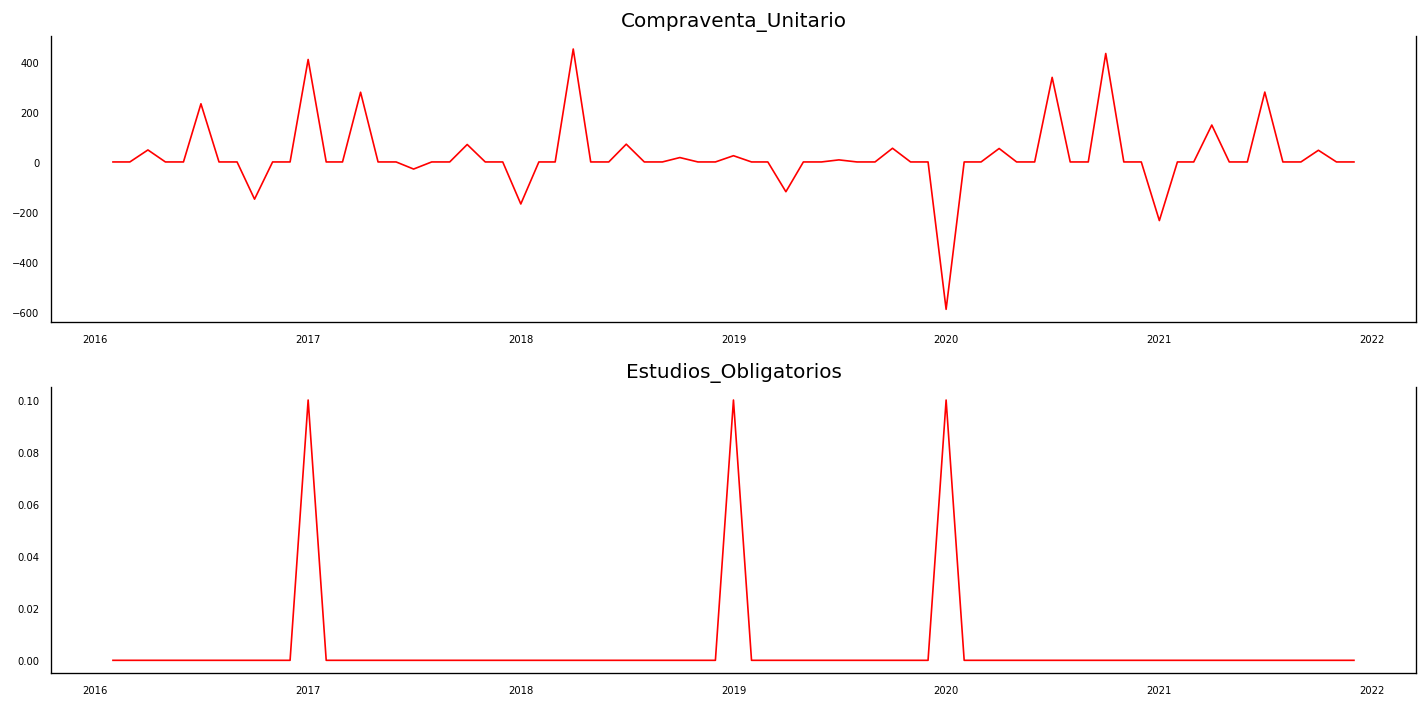

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.


#### Seleccionando el orden del modelo

In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
modelsel=model.select_order(20)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,1.934*,2.009*,6.914*,1.963*
1,2.082,2.309,8.022,2.169
2,2.228,2.607,9.296,2.373
3,2.360,2.890,10.63,2.563
4,2.500,3.182,12.27,2.760
5,2.634,3.468,14.13,2.953
6,2.718,3.703,15.50,3.094
7,2.847,3.983,17.87,3.281
8,2.964,4.252,20.43,3.456
9,2.986,4.426,21.36,3.536


En este caso, dado que todos los criterios (AIC, BIC, FPE y HQIC) indican que el orden 0 es el óptimo, se podría concluir que un modelo VAR no es necesario para los datos, ya que el mejor modelo sería uno sin autoregresiones (orden 0).

#### Ajustando el modelo

In [31]:
res = model.fit(maxlags=1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     17:38:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.41268
Nobs:                     70.0000    HQIC:                   2.29651
Log likelihood:          -270.350    FPE:                    9.20785
AIC:                      2.21995    Det(Omega_mle):         8.46659
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           25.954416        17.647416            1.471           0.141
L1.Compraventa_Unitario         -0.034351         0.122830           -0.280           0.780
L

La correlación entre los residuos de "Compraventa_Unitario" y "Estudios_Obligatorios" es de -0.118302, lo que sugiere una correlación negativa fuerte entre los residuos de estas dos variables en tu modelo.

In [32]:
res.is_stable()

True

In [33]:
X_train.columns

Index(['Compraventa_Unitario', 'Estudios_Obligatorios'], dtype='object')

###### Causalidad de Granger

In [34]:
grangercaus=res.test_causality(['Estudios_Obligatorios'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.1180,3.912,0.732,"(1, 134)"


In [35]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Estudios_Obligatorios'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.1083,3.912,0.743,"(1, 134)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=20
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Estudios_Obligatorios_x
Compraventa_Unitario_y,1.000,0.0
Estudios_Obligatorios_y,0.001,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de Estudios_Obligatorios

#### Diagnosis del modelo


###### Residuos

In [37]:
residuals=res.resid

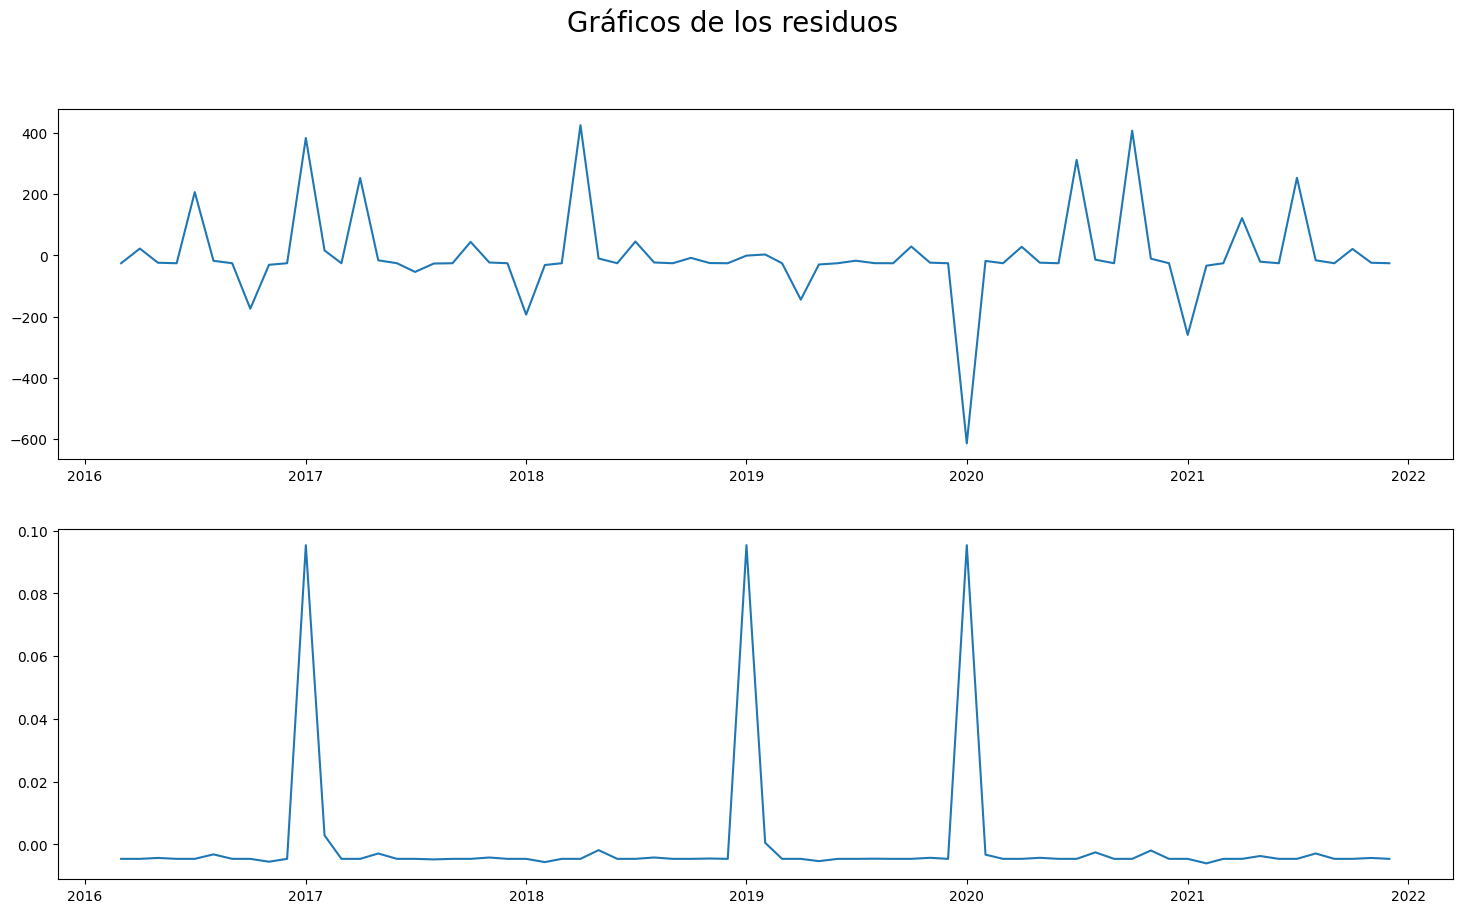

In [38]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [39]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[6.789115216603012e-13, 6.272404574315822e-13]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


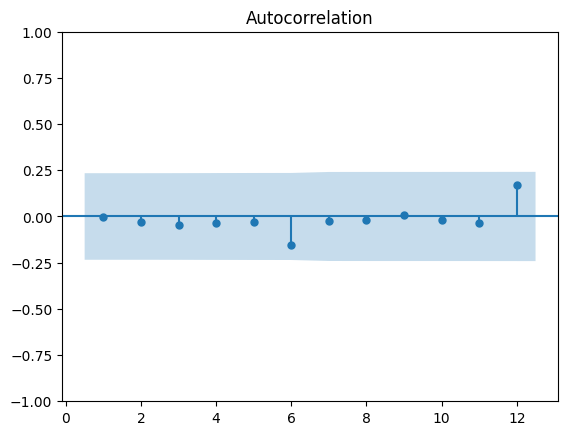

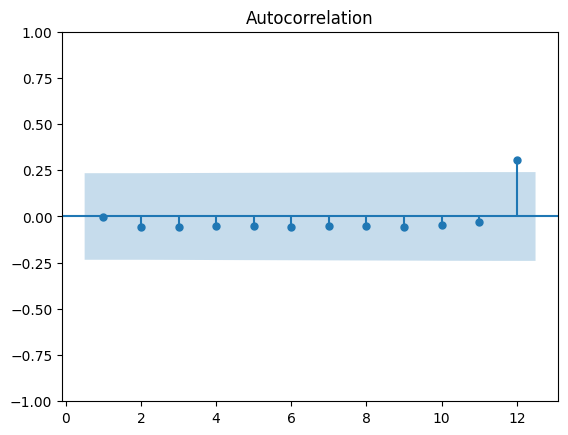

In [40]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 12 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:
- Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
- Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.

In [41]:
res = model.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     17:40:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.21536
Nobs:                     59.0000    HQIC:                   3.14201
Log likelihood:          -189.850    FPE:                    13.0493
AIC:                      2.45474    Det(Omega_mle):         6.43773
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            57.006321        33.173972            1.718           0.086
L1.Compraventa_Unitario          -0.038753         0.120803           -0.321           0.7

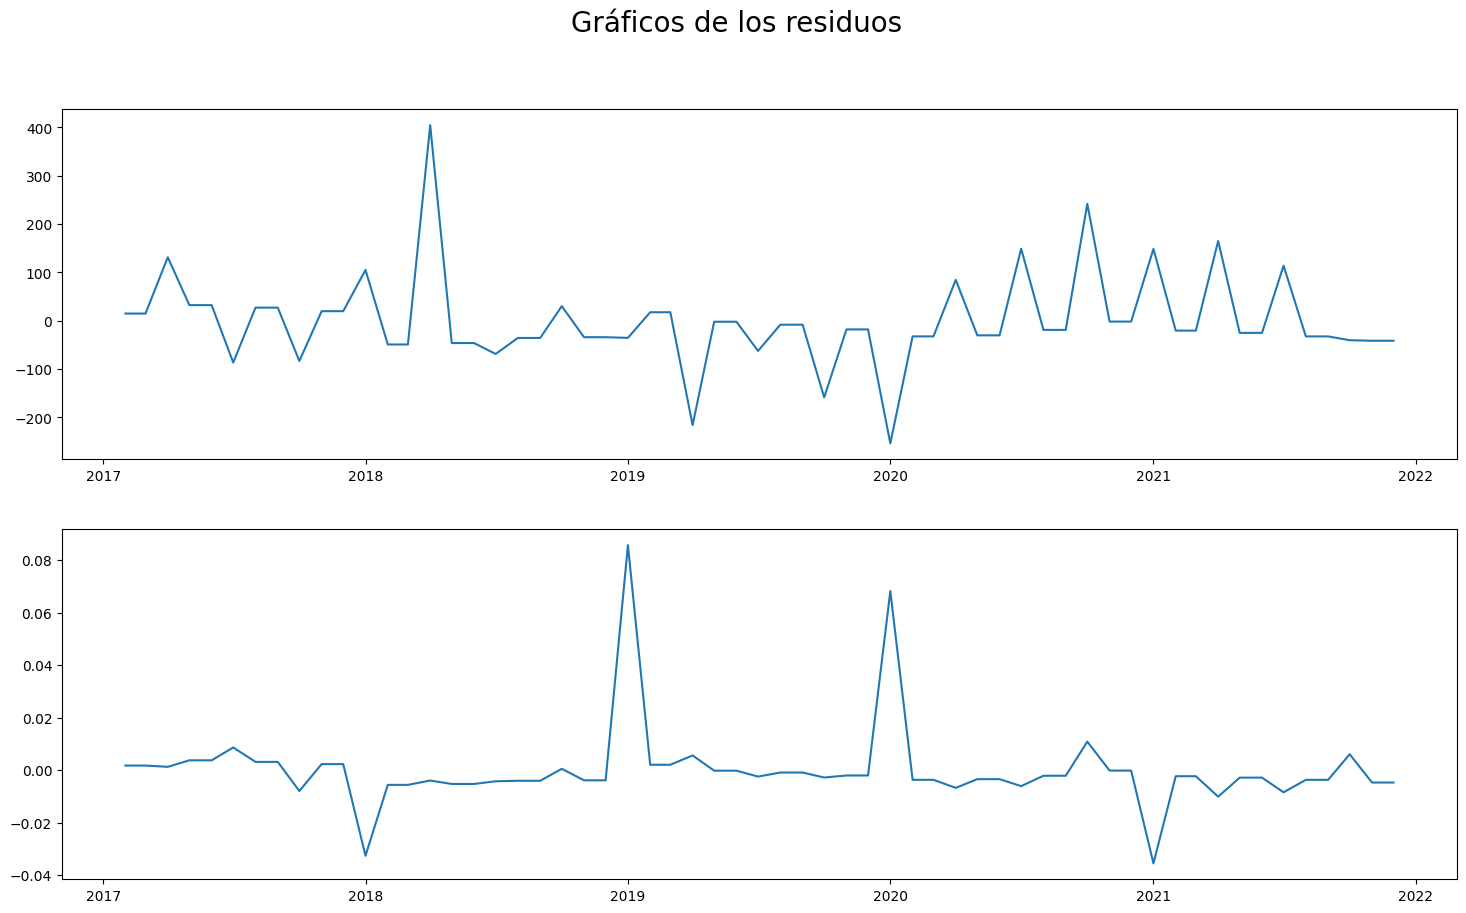

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

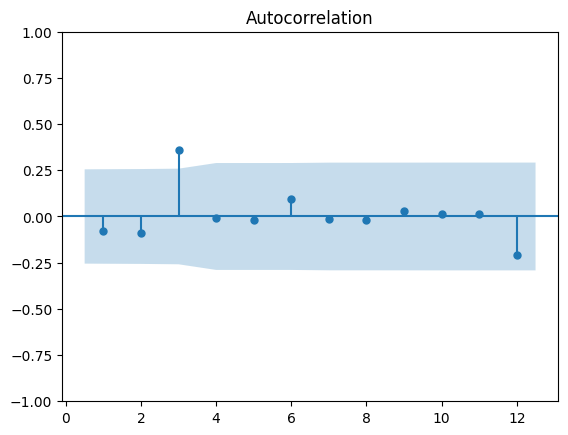

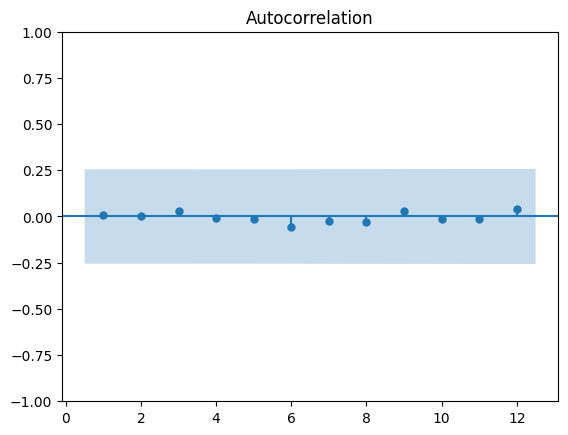

In [43]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

In [44]:
res = model.fit(3)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     17:41:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.94640
Nobs:                     68.0000    HQIC:                   2.67051
Log likelihood:          -263.617    FPE:                    12.0723
AIC:                      2.48945    Det(Omega_mle):         9.92394
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           27.476613        20.539604            1.338           0.181
L1.Compraventa_Unitario         -0.036366         0.128668           -0.283           0.777
L

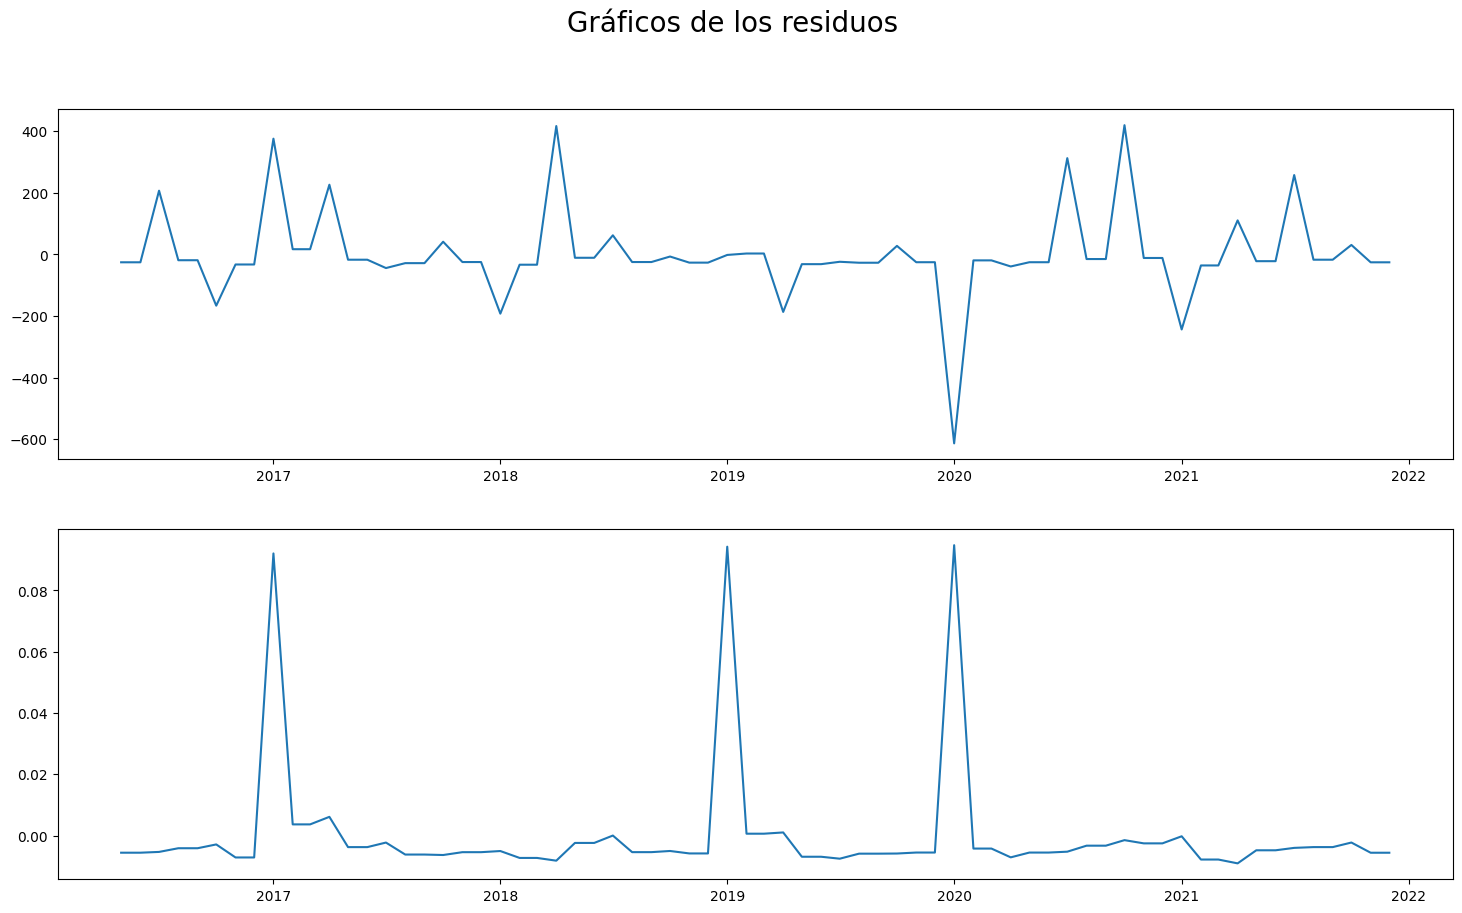

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

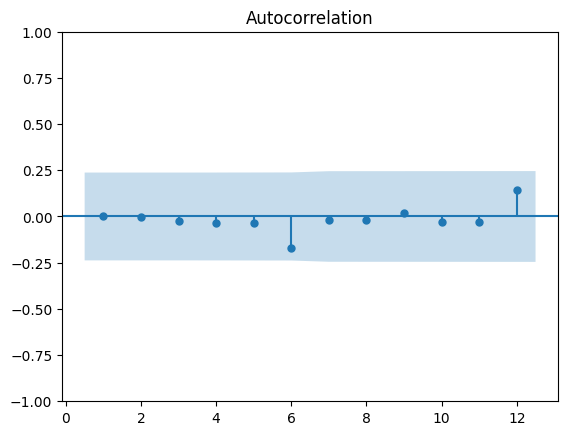

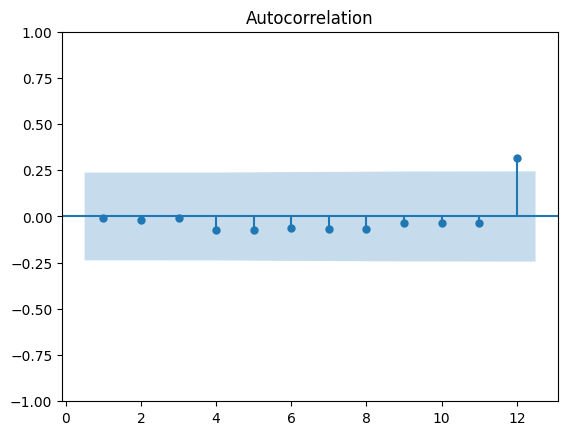

In [46]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

#### Valores predichos


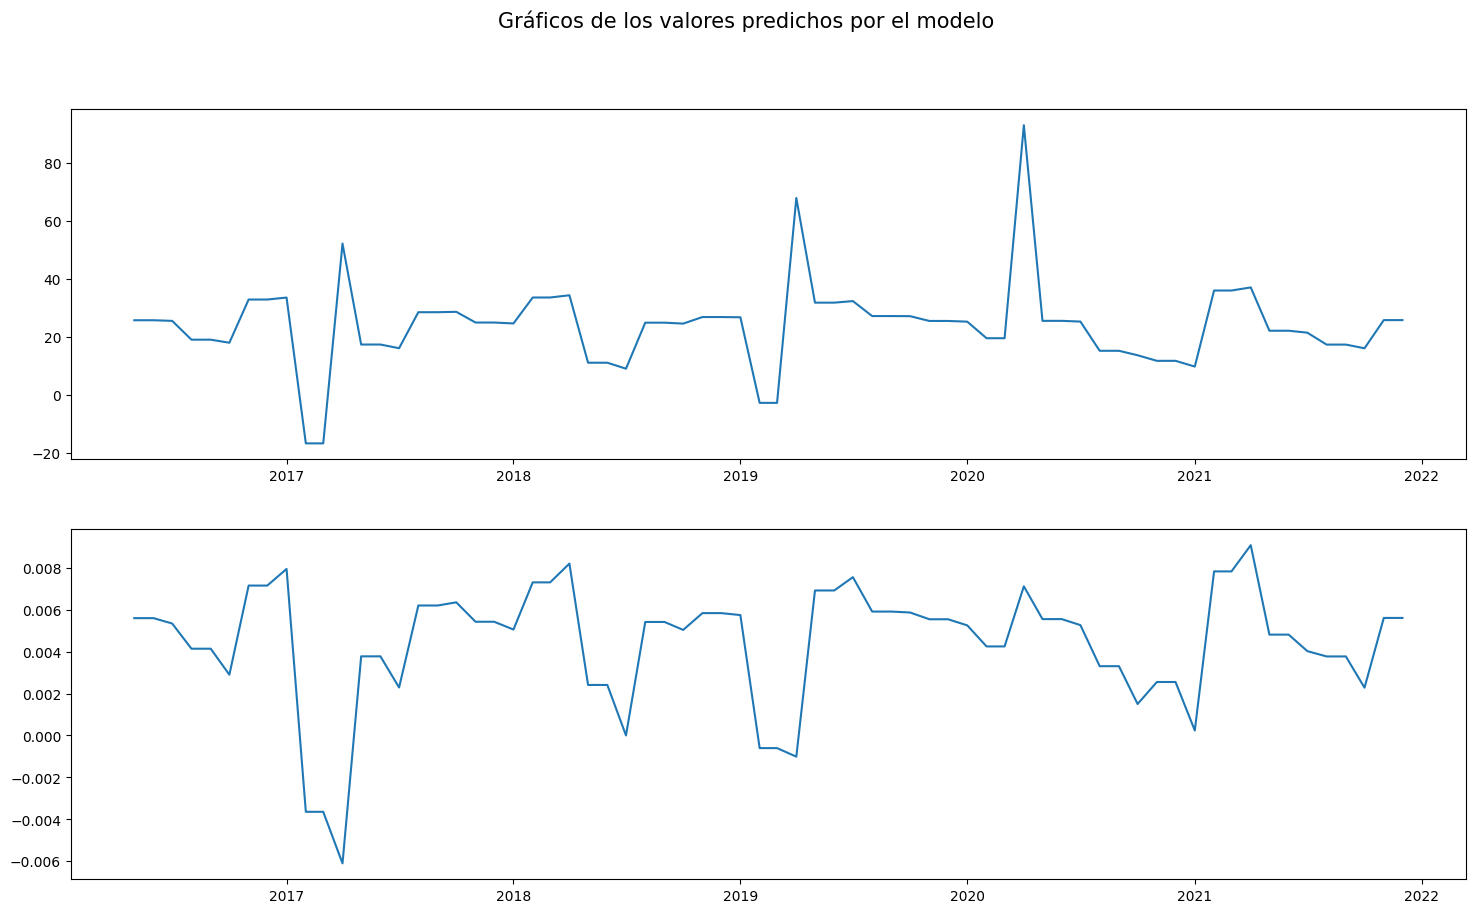

In [47]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [48]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 3
Predicciones:


,Compraventa_Unitario_pred,Estudios_Obligatorios_pred
Fecha,,
2022-01-01,25.567021,0.005358
2022-02-01,24.974356,0.005432
2022-03-01,22.471962,0.004888
2022-04-01,23.898076,0.004247
2022-05-01,24.339987,0.004334
2022-06-01,24.311331,0.004424
2022-07-01,23.920110,0.004433
2022-08-01,23.924304,0.004418
2022-09-01,23.978469,0.004416


<Figure size 1200x1000 with 0 Axes>

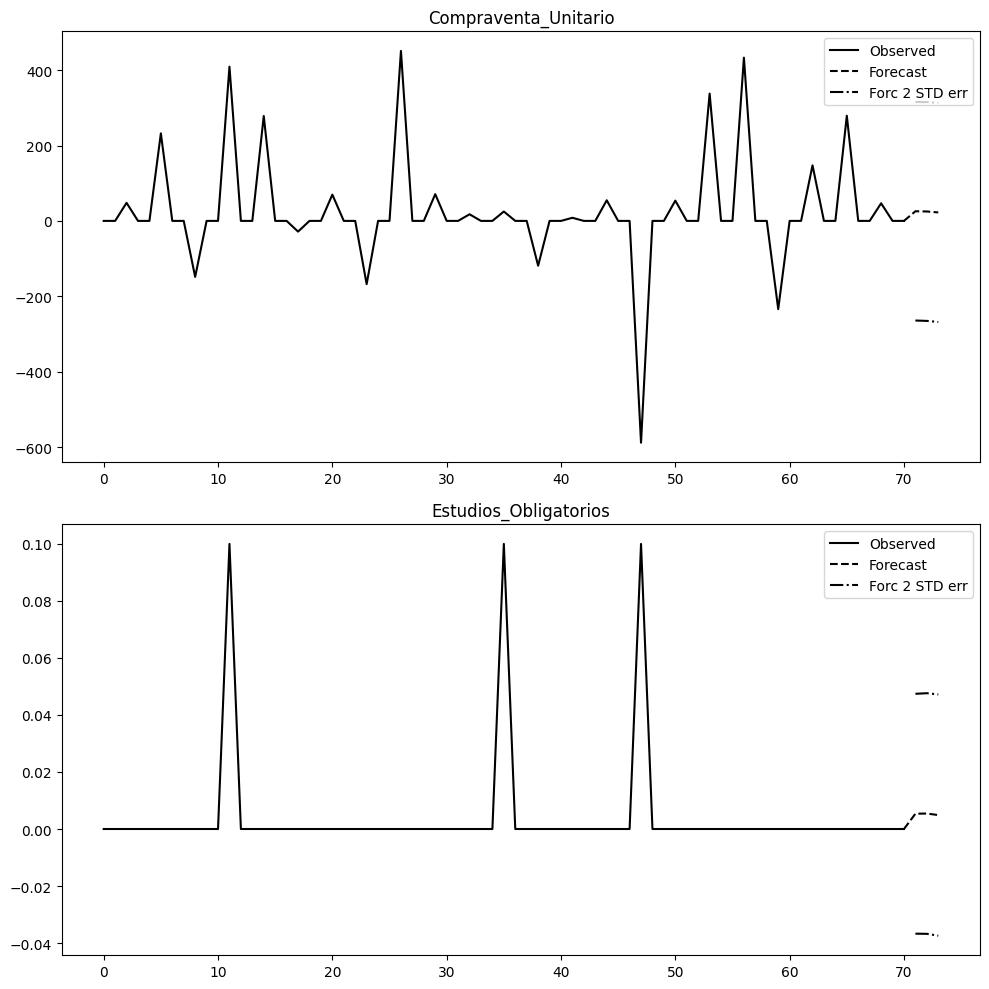

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [50]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [51]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2022-01-01,5899.783687,99.505358
2022-02-01,5924.758043,99.510790
2022-03-01,5947.230006,99.515678
2022-04-01,5971.128082,99.519924
2022-05-01,5995.468069,99.524258
2022-06-01,6019.779399,99.528682
2022-07-01,6043.699509,99.533115
2022-08-01,6067.623814,99.537533
2022-09-01,6091.602283,99.541949


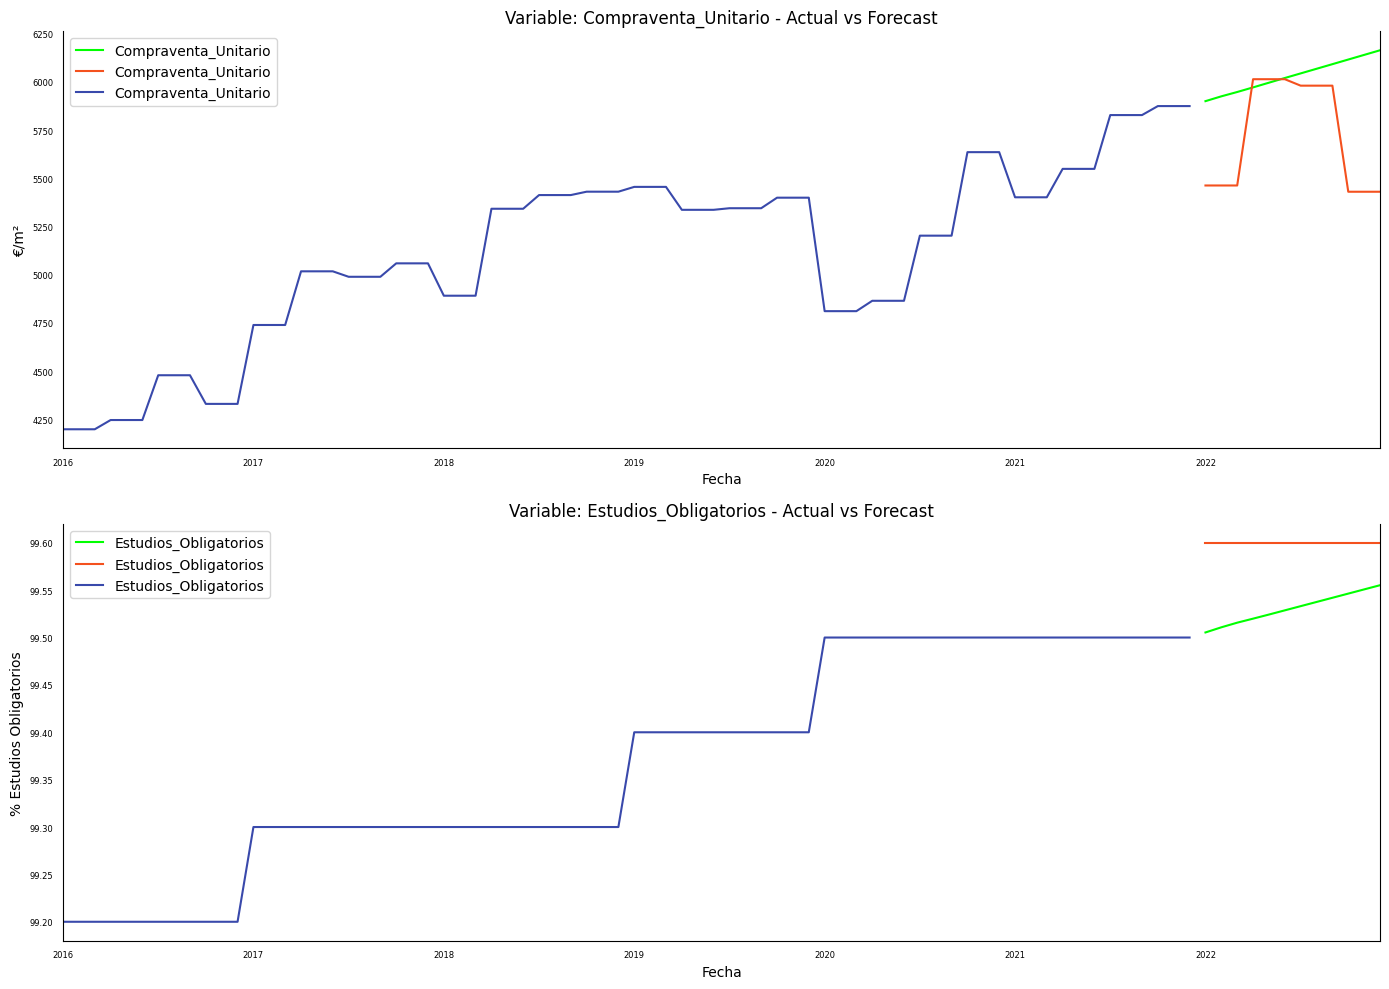

In [52]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Estudios Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [53]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [54]:
for i in ['Compraventa_Unitario','Estudios_Obligatorios']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 181514.9913349764
MAE is : 320.2243864529121
RMSE is : 426.0457620197347
MAPE is : 5.837705414449534
R2 is : -1.3859896292306897

Evaluation metric for Estudios_Obligatorios
Evaluation metric results:-
MSE is : 0.005025871408076555
MAE is : 0.06919506736972043
RMSE is : 0.07089338056600598
MAPE is : 0.06947295920654664
R2 is : 0.0



Las métricas de evaluación indican que el modelo para Compraventa_Unitario tiene un rendimiento deficiente, con un alto MSE (181514.99) y un R2 negativo (-1.39), sugiriendo que no se ajusta bien a los datos. Por otro lado, el modelo para Estudios_Obligatorios muestra un bajo MSE (0.005) y MAPE (0.069%), indicando buenos resultados en términos de errores absolutos y relativos, aunque su R2 es 0.0, sugiriendo que no explica la varianza de los datos.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 310.557702849632
Root mean squared error: 516.6186639337419


### Modelo VECM (Vector Error Correction Model

#### Ajustando el modelo

In [55]:
from statsmodels.tsa.vector_ar.vecm import select_order

In [56]:
# Seleccionar el número óptimo de retardos basado en criterios de información
order_selection = select_order(X_train, maxlags=8) #Dado que una de las series tiene datos trimestrales(8) y la otra anual(30)
print(order_selection.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      2.309*      2.513*      10.06*      2.389*
1       2.423       2.763       11.29       2.557
2       2.535       3.011       12.64       2.722
3       2.647       3.259       14.17       2.888
4       2.755       3.503       15.83       3.049
5       2.858       3.742       17.63       3.206
6       2.960       3.980       19.65       3.361
7       3.066       4.223       22.06       3.521
8       3.168       4.460       24.69       3.676
-------------------------------------------------


In [57]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [61]:
# Usar el número óptimo de retardos seleccionado
optimal_lags = order_selection.aic  # Por ejemplo, puedes usar el criterio AIC
model = VECM(X_train, k_ar_diff=optimal_lags)

In [62]:
vecm_fit = model.fit()

In [63]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0372,0.018,-2.055,0.040,-0.073,-0.002
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-4.343e-06,2.68e-06,-1.619,0.106,-9.6e-06,9.16e-07
,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-59.1383,3.216,-18.391,0.000,-65.441,-52.836


El análisis indica que las dos series están cointegradas y tienen una relación dinámica de ajuste hacia un equilibrio común. Los resultados sugieren que ajustes en "Estudios_Obligatorios" tienen un efecto significativo en "Compraventa_Unitario", mientras que los ajustes en "Compraventa_Unitario" tienen un impacto relativamente menor en "Estudios_Obligatorios" basado en los coeficientes de carga más pequeños.

In [64]:
stability_test = vecm_fit.test_whiteness(nlags=12)
print(stability_test.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         40.25          62.83   0.711 46
----------------------------------------


#### Diagnosis del modelo


#####Residuos

In [65]:
residuals=vecm_fit.resid

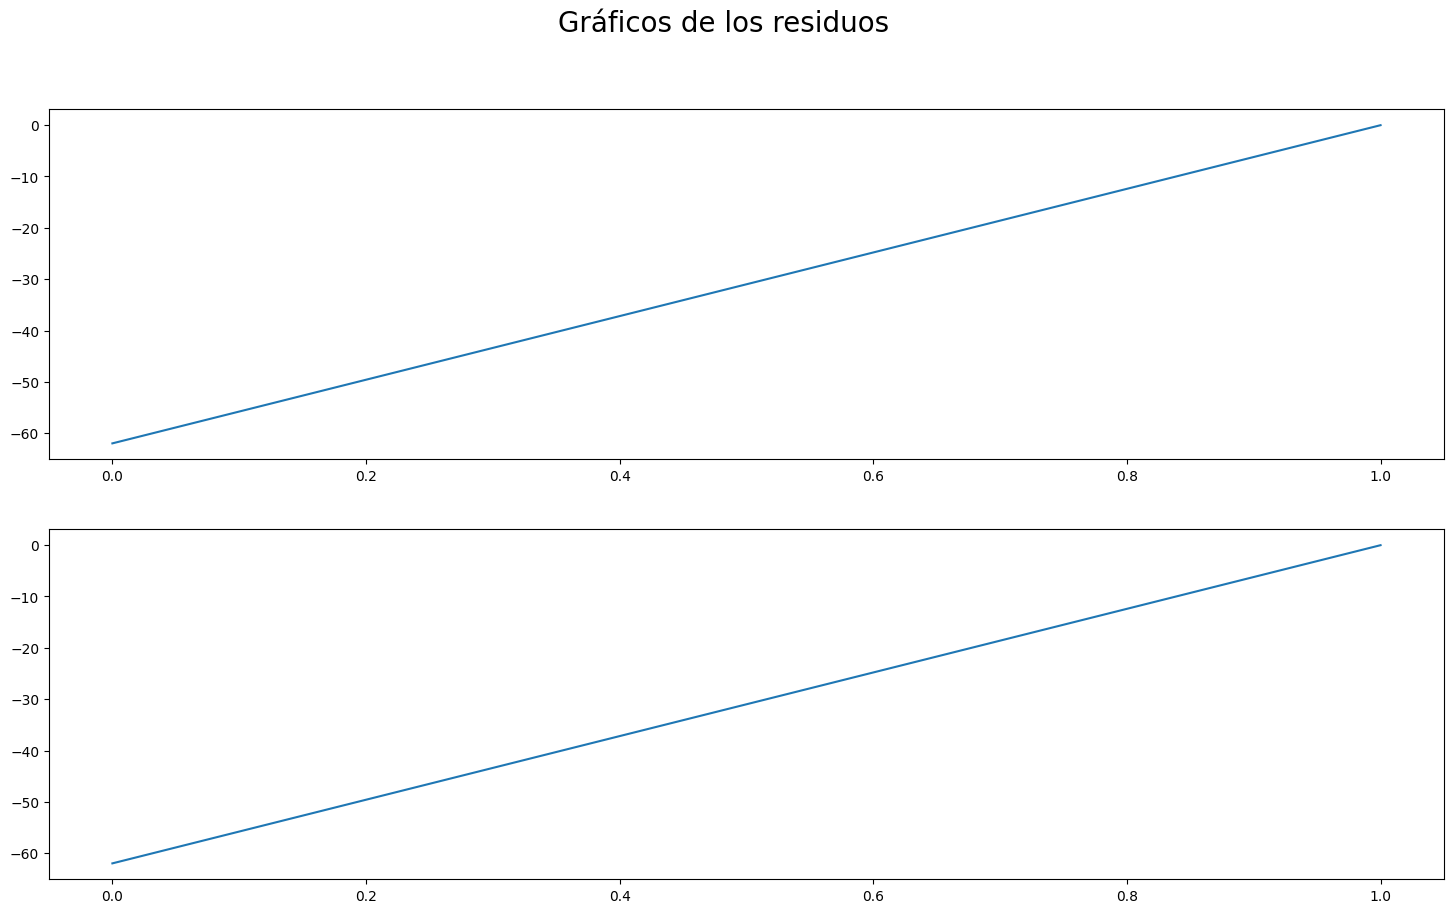

In [66]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals[i]) for i in range(2)]
plt.show()

##### Dickey - Fuller a los residuos


In [67]:
import statsmodels.tsa.stattools as ts

In [68]:
# Realizar la prueba ADF en cada serie de residuos y imprimir los resultados
print('ADF de los Residuos, p-valores:')
for i in range(residuals.shape[1]):
    result = ts.adfuller(residuals[:, i])
    print(f'Variable {i+1}: Estadístico ADF = {result[0]:.4f}, P-valor = {result[1]:.4f}')

ADF de los Residuos, p-valores:
Variable 1: Estadístico ADF = -8.4525, P-valor = 0.0000
Variable 2: Estadístico ADF = -8.6196, P-valor = 0.0000


Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.

#####ACF de los Residuos

In [69]:
import statsmodels.api as sm

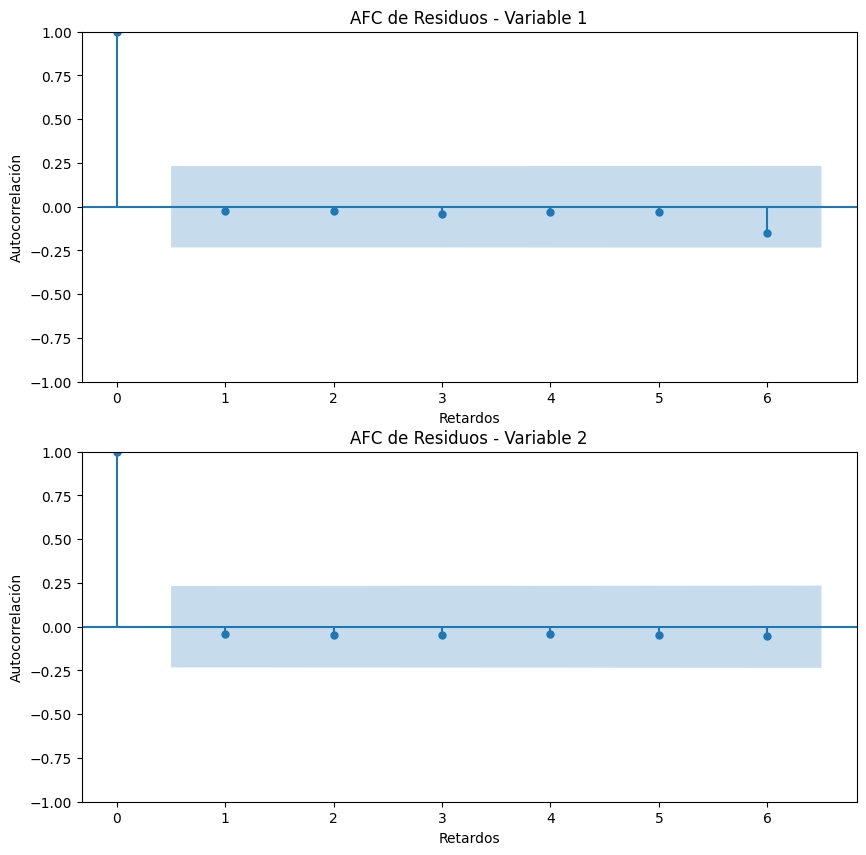

In [70]:
# Realizar y graficar la función de autocorrelación para cada serie de residuos
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 10))
for i in range(residuals.shape[1]):
    sm.graphics.tsa.plot_acf(residuals[:, i], lags=6, ax=axes[i], title=f'AFC de Residuos - Variable {i+1}')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].set_xlabel('Retardos')

Esto sugiere que los residuos de la Variable 1  y 2 son aproximadamente ruido blanco, indicando un buen ajuste del modelo para esta variable. No hay evidencia de autocorrelaciones remanentes que el modelo no haya capturado.


#### Valores predichos

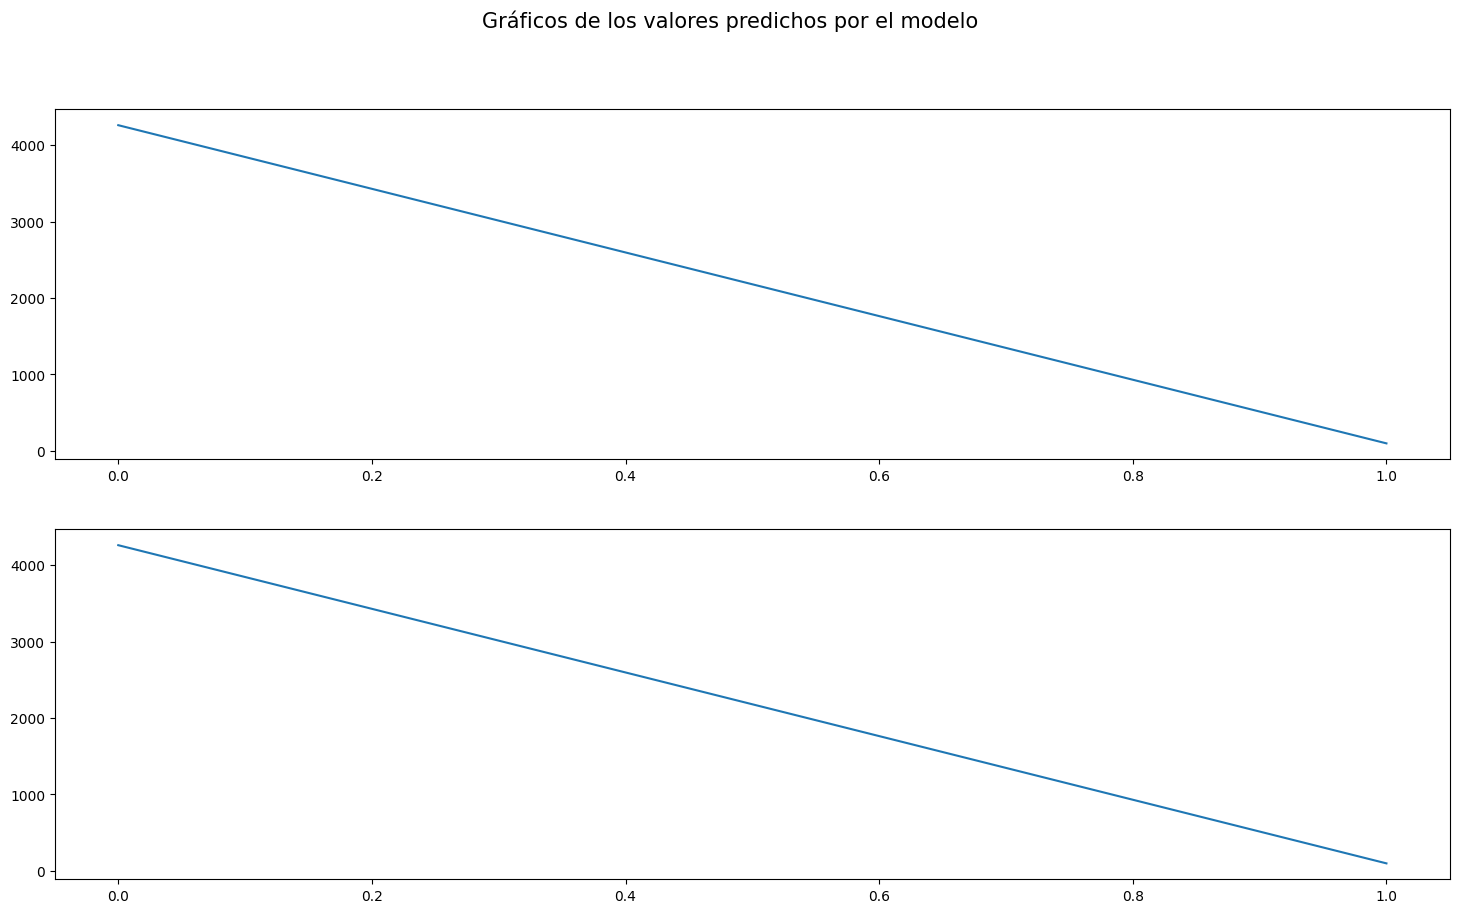

In [71]:
y_fitted = vecm_fit.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted[i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [72]:
# Obtener los últimos valores (lag_order número de valores)
lag_order = vecm_fit.k_ar
last_observations = data[-lag_order:]

# Hacer predicciones para los próximos n pasos
n_steps = 12
forecast = vecm_fit.predict(n_steps)

pred = (pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns))
pred

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2022-01-01,5874.589999,99.500044
2022-02-01,5874.949557,99.500086
2022-03-01,5875.295849,99.500126
2022-04-01,5875.629364,99.500165
2022-05-01,5875.950575,99.500203
2022-06-01,5876.259934,99.500239
2022-07-01,5876.557880,99.500274
2022-08-01,5876.844833,99.500307
2022-09-01,5877.121199,99.500340


<Figure size 1200x1000 with 0 Axes>

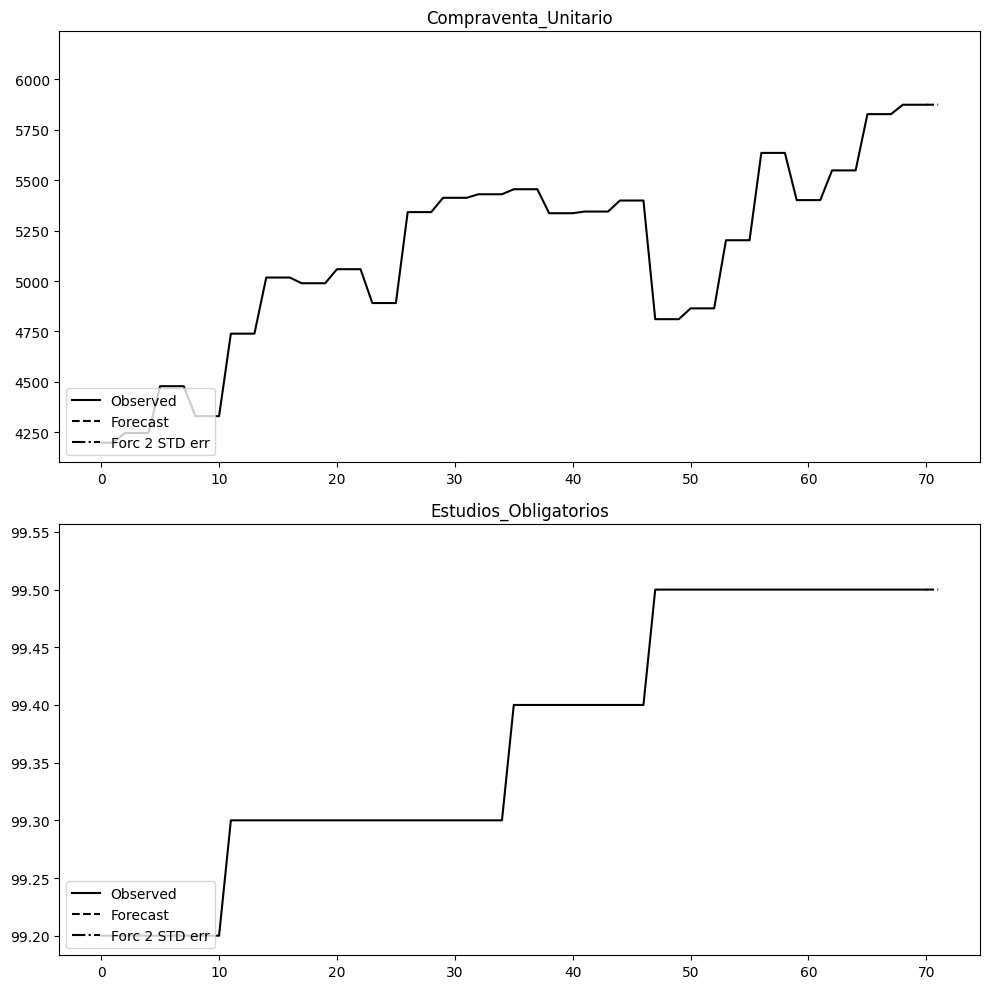

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
vecm_fit.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

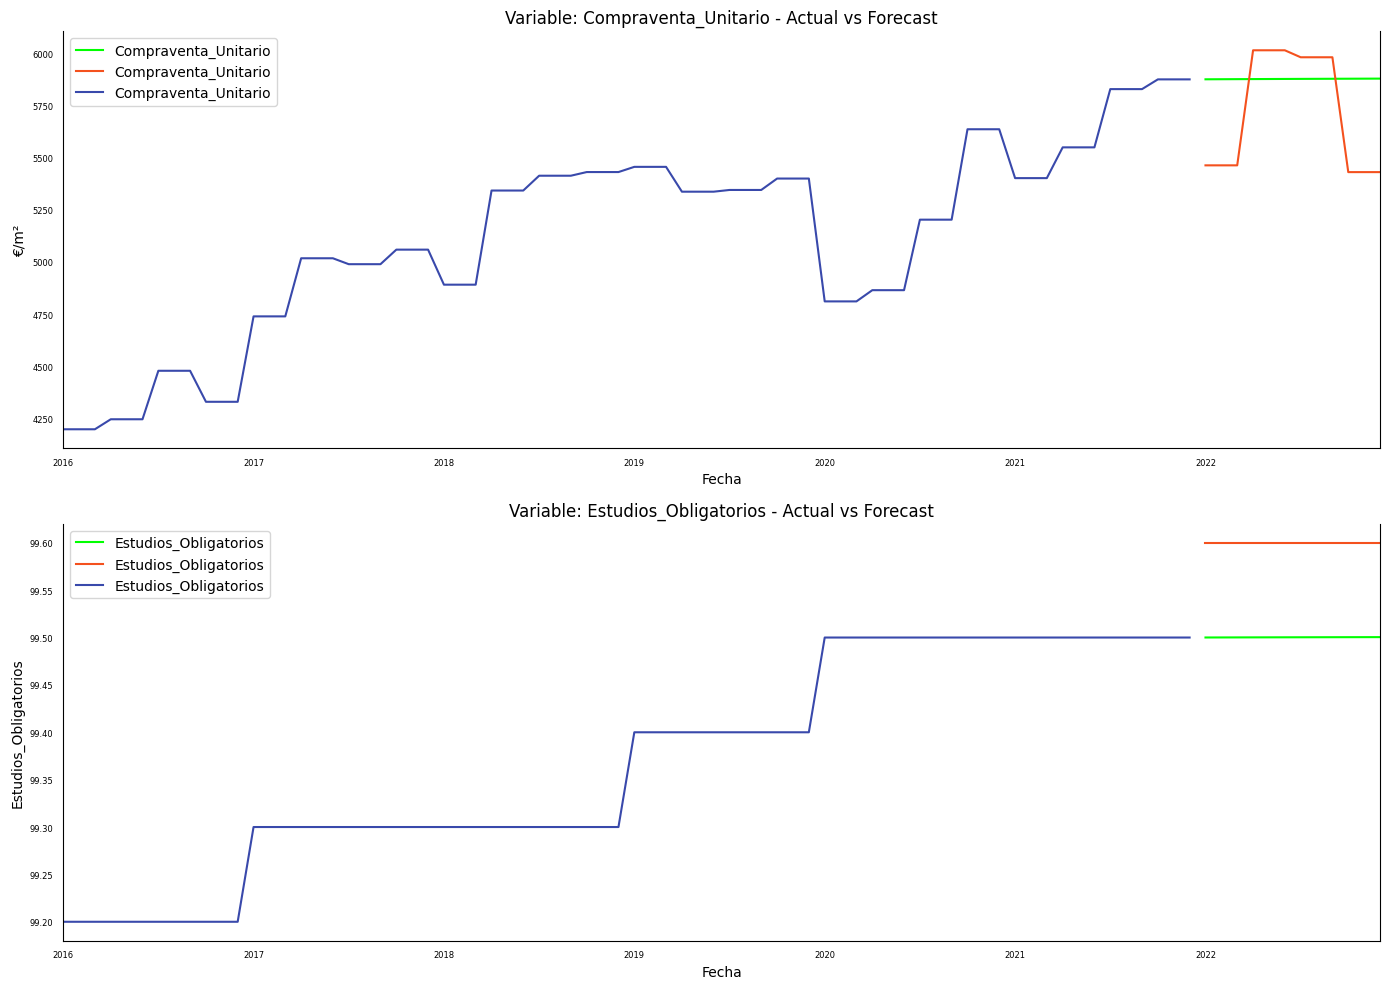

In [74]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Estudios_Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [75]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [76]:
for i in ['Compraventa_Unitario','Estudios_Obligatorios']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 100046.66056541202
MAE is : 275.27444273234397
RMSE is : 316.3015342444801
MAPE is : 4.953009923398213
R2 is : -0.31509961129165776

Evaluation metric for Estudios_Obligatorios
Evaluation metric results:-
MSE is : 0.0099503517533335
MAE is : 0.09975137645379324
RMSE is : 0.09975144988085888
MAPE is : 0.10015198439135872
R2 is : 0.0



Las métricas de evaluación indican que el modelo VECM no predice bien Compraventa_Unitario, con un alto MSE (100046.66), RMSE (316.30), y un R² negativo (-0.315), sugiriendo un mal ajuste. En contraste, Estudios_Obligatorios muestra errores bajos (MSE: 0.00995, RMSE: 0.09975), pero un R² de 0, indicando que el modelo no captura su variabilidad.

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 137.6870970543989
Root mean squared error: 223.6589708862175


##Conclusiones

En resumen, el análisis de series temporales para "Compraventa_Unitario" y "Estudios_Obligatorios" en el distrito de Sarrià-Sant Gervasi revela una alta correlación (75%) y tendencias al alza. Sin embargo, la cointegración y la estacionariedad presentan desafíos para el modelado. La prueba de cointegración de Johansen muestra que "Compraventa_Unitario" es cointegrado, mientras que "Estudios_Obligatorios" no lo es. Las pruebas de estacionariedad indican que ambas series no son estacionarias en su forma original pero se vuelven estacionarias después de la diferenciación.

El modelo VAR ajustado, aunque muestra estacionariedad en los residuos y un buen ajuste a corto plazo, no evidencia una relación causal de Granger significativa entre las series. Las predicciones del modelo VAR para "Compraventa_Unitario" son pobres, con un alto MSE y un R² negativo, mientras que "Estudios_Obligatorios" muestra un mejor rendimiento en términos de error absoluto y relativo.

El modelo VECM indica cointegración y muestra que las series tienen una relación dinámica, con "Estudios_Obligatorios" influyendo en "Compraventa_Unitario". Sin embargo, aunque los residuos del VECM son estacionarios y no presentan autocorrelación significativa, el modelo no captura adecuadamente la variabilidad de "Compraventa_Unitario", reflejado en un MSE alto y un R² negativo. En contraste, el VECM ajusta bien "Estudios_Obligatorios" en términos de errores absolutos, aunque su R² es cero, indicando que no explica la varianza de los datos.

En conclusión, ambos modelos muestran limitaciones significativas, con el VAR fallando en capturar relaciones causales y el VECM no logrando predecir adecuadamente "Compraventa_Unitario". Se necesitan mejoras y ajustes adicionales, posiblemente considerando modelos más avanzados o variables adicionales, para lograr predicciones más precisas en este contexto.